<a href="https://colab.research.google.com/github/Srividhya-Sainath/Experimenting_with_PyTorch/blob/main/First_GAN_with_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**CHAPTER 1 - Understanding PyTorch Tensors**

In [ ]:
import torch

PyTorch has its own kind of variables for storing numbers. They are called PyTorch tensors.

In [ ]:
# simple pytorch tensor
x = torch.tensor(3.5)
print(x)
# simple arithmetic with tensors
y = x + 3
print(y) # numpy arrays work similarly as pytorch tensors #

tensor(3.5000)
tensor(6.5000)


Automatic gradients with PyTorch makes these tensors more special. They memorise the relationship each tensor has with other tensors, which comes handy while calculating gradients.

In [ ]:
x = torch.tensor(3.5, requires_grad=True)
print(x)

tensor(3.5000, requires_grad=True)


In [ ]:
# y id defined as a function of x 
y = (x-1)*(x-2)*(x-3)
print(y)

tensor(1.8750, grad_fn=<MulBackward0>)


In [ ]:
# work out gradient
y.backward()

In [ ]:
# what is the gradient at x = 3.5
x.grad

tensor(5.7500)

In [ ]:
# set up simple graph relating x,y and z
x = torch.tensor(3.5, requires_grad=True)
y = x*x
z = 2*y + 3

In [ ]:
# work out gradient
z.backward()

In [ ]:
# what is the gradient at x = 3.5
x.grad

tensor(14.)

**CHAPTER 2 - First PyTorch Neural Network** 

In [ ]:
# mount Drive to access data files
from google.colab import drive
drive.mount('./mount')

Drive already mounted at ./mount; to attempt to forcibly remount, call drive.mount("./mount", force_remount=True).


In [ ]:
# import pandas to read csv files
import pandas

In [ ]:
df = pandas.read_csv('mount/My Drive/mnist_data/mnist_train.csv', header=None)

In [ ]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, 0 to 784
dtypes: int64(785)
memory usage: 359.3 MB


In [ ]:
# import matplotlib to show Images
import matplotlib.pyplot as plt

In [ ]:
# get data from dataframe
row = 0
data = df.iloc[row]

In [ ]:
# label is the first value
label = data[0]

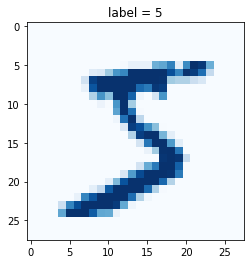

In [ ]:
# image data is the remaining 784 values
img = data[1:].values.reshape(28,28)
plt.title("label = "+ str(label))
plt.imshow(img,interpolation='none', cmap='Blues')
plt.show()

In [ ]:
# import libraries
import torch.nn as nn

In [ ]:
# build neural network class called classifier
class Classifier(nn.Module):
  def __init__(self):
    # initialise parent pytorch class
    super().__init__()

    # define neural network layers
    self.model = nn.Sequential(
        nn.Linear(784,200),
        nn.LeakyReLU(0.02),
        nn.LayerNorm(200),
        nn.Linear(200,10),
        nn.Sigmoid()
    )

    # create loss function
    self.loss_function = nn.BCELoss()

    # create optimiser, using simple stochastic gradient descent
    self.optimiser = torch.optim.Adam(self.parameters(), lr=0.01)

    # counter and accumlator for progress
    self.counter = 0
    self.progress = []
    pass
  
  def forward(self,inputs):
    # simply run model
    return self.model(inputs)

  def train(self,inputs,targets):
    # calculate the output of the network
    outputs = self.forward(inputs)

    # calculate loss
    loss = self.loss_function(outputs,targets)

     # increase counter and accumulate error every 10 training examples
    self.counter += 1
    if (self.counter % 10 == 0):
      self.progress.append(loss.item())
      pass
    if (self.counter % 10000 == 0):
      print("counter = ", self.counter)
      pass
    # zero gradients, performs a backward pass and update the weights
    self.optimiser.zero_grad() # All the gradients in the computation graph is set to zero
    loss.backward() # Gradients are calculated as backward propagation is carried out
    self.optimiser.step() # Gradients are then used to update the parameters  
    
    # plot progress of loss in the form of a chart
  def plot_progress(self):
    df = pandas.DataFrame(self.progress, columns=['loss'])
    df.plot(ylim=(0,1.0),figsize=(16,8),alpha=0.1,marker='.',grid=True,yticks=(0,0.25,0.5))
    pass

In [ ]:
# create dataset class using pytorch libraries
from torch.utils.data import Dataset

class MnistDataset(Dataset):
  def __init__(self,csv_file):
    self.data_df = pandas.read_csv(csv_file,header=None)
    pass

  def __len__(self):
    return len(self.data_df)

  def plot_image(self,index):
    arr = self.data_df.iloc[index,1:].values.reshape(28,28)
    plt.title("label = " + str(self.data_df.iloc[index,0]))
    plt.imshow(arr, interpolation='none', cmap='Blues')
    pass  

  def __getitem__(self,index):
    # image target (label)
    label = self.data_df.iloc[index,0] # [row number,column number]
    target = torch.zeros((10))
    target[label] = 1.0

    # image data, normalised from 0-255 to 0-1
    image_values = torch.FloatTensor(self.data_df.iloc[index,1:].values) / 255.0

    # return label, image data tensor and target tensor
    return label, image_values, target
  pass

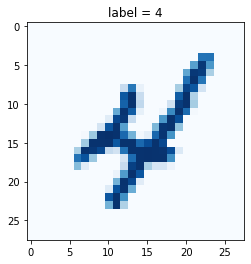

In [ ]:
# Checking if all works well
mnist_dataset = MnistDataset('mount/My Drive/mnist_data/mnist_train.csv')
mnist_dataset.plot_image(9)

**Training our Classifier**

In [ ]:
%%time
# create neural network
C = Classifier()

# train network on MNIST dataset
epochs = 3

for i in range(epochs):
  print('training epoch', i+1, 'of', epochs)
  for label, image_data_tensor, target_tensor in mnist_dataset:
    C.train(image_data_tensor, target_tensor)
    pass
  pass  

training epoch 1 of 3
counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
training epoch 2 of 3
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
training epoch 3 of 3
counter =  130000
counter =  140000
counter =  150000
counter =  160000
counter =  170000
counter =  180000
CPU times: user 9min 10s, sys: 4.6 s, total: 9min 15s
Wall time: 9min 14s


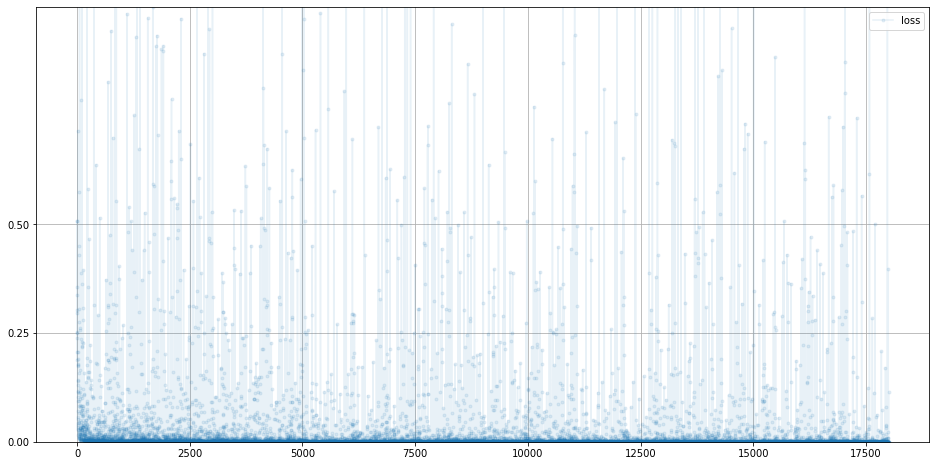

In [ ]:
# plot classifier error
C.plot_progress()

**Querying our Neural Network**

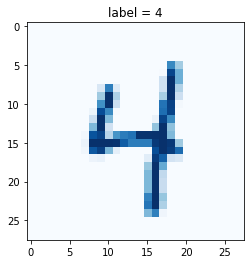

In [ ]:
# load MNIST test data
mnist_test_dataset = MnistDataset('mount/My Drive/mnist_data/mnist_test.csv')

# pick a record
record = 19

# plot image and correct label
mnist_test_dataset.plot_image(record)

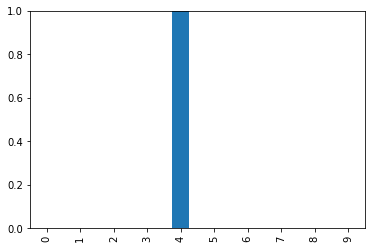

In [ ]:
image_data = mnist_test_dataset[record][1]

# query from trained network
output = C.forward(image_data)
output_cpu = output.cpu()

# plot output tensor
pandas.DataFrame(output_cpu.detach().numpy()).plot(kind='bar',legend=False,ylim=(0,1))

In [ ]:
# test trained neural network on training data

score = 0 # Number of times my network got it right
items = 0 # Number of test examples

for label, image_data_tensor, target_tensor in mnist_test_dataset:
  answer = C.forward(image_data_tensor)
  answer_cpu = answer.cpu().detach().numpy()
  if (answer_cpu.argmax() == label):
    score += 1
    pass
  items += 1
  pass

print(score, items, score/items)

9568 10000 0.9568


**CHAPTER 3 - CUDA Basics**

In [ ]:
# Create tensor on the GPU
x = torch.cuda.FloatTensor([3.5])

In [ ]:
# Check if CUDA is available at the beginning of a python notebook
if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  print("using cuda:", torch.cuda.get_device_name(0))
  pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

using cuda: Tesla T4


device(type='cuda')

**CHAPTER 4 - The GAN Idea**

In [ ]:
import torch
import torch.nn as nn
import pandas
import matplotlib.pyplot as plt

In [ ]:
import random

In [ ]:
def generate_real():
  real_data = torch.cuda.FloatTensor([random.uniform(0.8,1.0),random.uniform(0.0,0.2),random.uniform(0.8,1.0),random.uniform(0.0,0.2)])
  return real_data

In [ ]:
generate_real()

tensor([0.9047, 0.1696, 0.9334, 0.0781])

In [ ]:
## Building Discriminator Class
# discriminator class

class Discriminator(nn.Module): 
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            nn.Linear(4, 3),
            nn.Sigmoid(),
            nn.Linear(3, 1),
            nn.Sigmoid()
        )
        
        # create loss function
        self.loss_function = nn.MSELoss()

        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []

        pass
    
    
    def forward(self, inputs):
        # simply run model
        return self.model(inputs)
    
    
    def train(self, inputs, targets):
        # calculate the output of the network
        outputs = self.forward(inputs)
        
        # calculate loss
        loss = self.loss_function(outputs, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
        pass
    
    pass

In [ ]:
# Testing the Discriminator

def generate_random(size):
  random_data = torch.rand(size)
  return random_data

In [ ]:
generate_random(4)

tensor([0.1211, 0.2435, 0.5499, 0.1442])

counter =  10000
counter =  20000


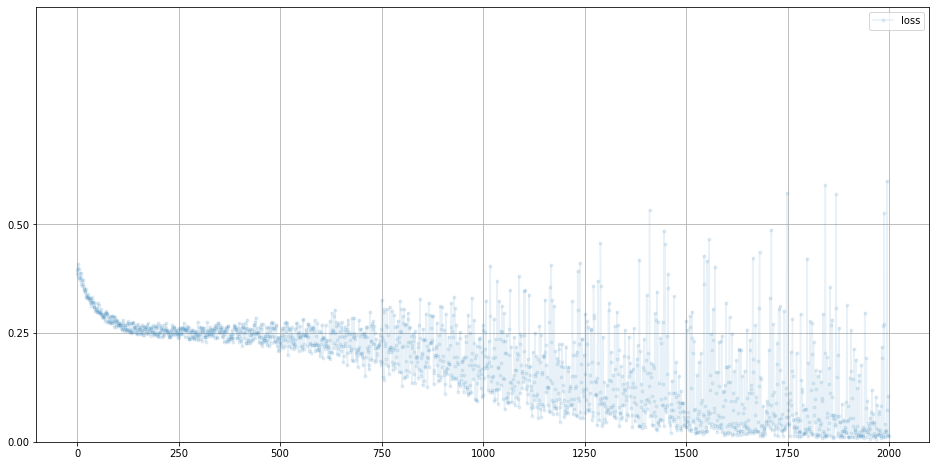

In [ ]:
# plot discriminator loss
D = Discriminator()

for i in range(10000):
    # real data
    D.train(generate_real(), torch.cuda.FloatTensor([1.0]))
    # fake data
    D.train(generate_random(4), torch.cuda.FloatTensor([0.0]))
    pass

D.plot_progress()

In [ ]:
# manually run discriminator to check it can tell real data from fake
print( D.forward( generate_real() ).item() )
print( D.forward( generate_random(4) ).item() )

0.7332083582878113
0.25102725625038147


In [ ]:
# generator class

class Generator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            nn.Linear(1, 3),
            nn.Sigmoid(),
            nn.Linear(3, 4),
            nn.Sigmoid()
        )

        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []
        
        pass
    
    
    def forward(self, inputs):        
        # simply run model
        return self.model(inputs)
    
    
    def train(self, D, inputs, targets):
        # calculate the output of the network
        g_output = self.forward(inputs)
        
        # pass onto Discriminator
        d_output = D.forward(g_output)
        
        # calculate error
        loss = D.loss_function(d_output, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
        pass
    
    pass

In [ ]:
# check the generator output is of the right type and shape

G = Generator()

G.forward(torch.cuda.FloatTensor([0.5]))

tensor([0.3696, 0.5134, 0.4761, 0.4515], grad_fn=<SigmoidBackward0>)

In [ ]:
%%time 

# create Discriminator and Generator

D = Discriminator()
G = Generator()

image_list = []

# train Discriminator and Generator

for i in range(10000):
    
    # train discriminator on true
    D.train(generate_real(), torch.cuda.FloatTensor([1.0]))
    
    # train discriminator on false
    # use detach() so gradients in G are not calculated
    G_output = G.forward(torch.cuda.FloatTensor([0.5]).detach())
    D.train(G_output, torch.cuda.FloatTensor([0.0]))
    
    # train generator
    G.train(D, torch.cuda.FloatTensor([0.5]), torch.cuda.FloatTensor([1.0]))
    
    # add image to list every 1000
    if (i % 1000 == 0):
      G_input = G.forward(torch.cuda.FloatTensor([0.5]))
      G_input_cpu = G_input.cpu()
      image_list.append( G_input_cpu.detach().numpy() )

    pass

counter =  10000
counter =  20000
CPU times: user 30.3 s, sys: 1.03 s, total: 31.3 s
Wall time: 30.9 s


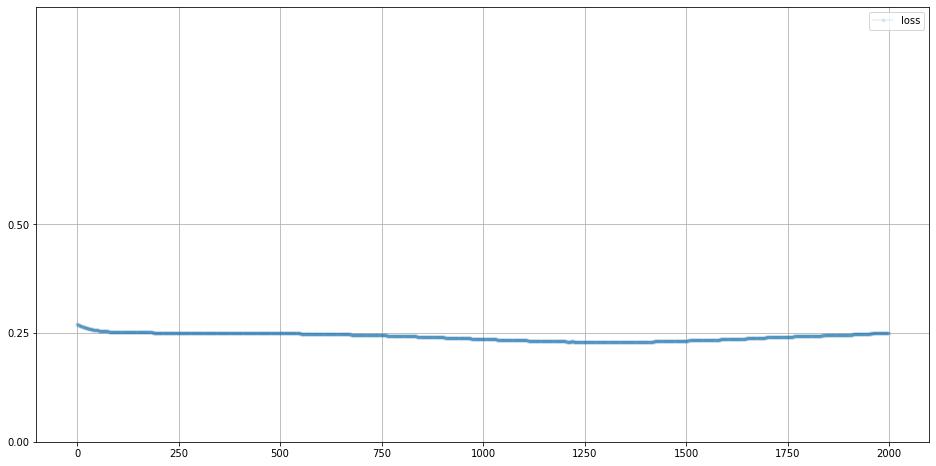

In [ ]:
# plot discriminator error

D.plot_progress()

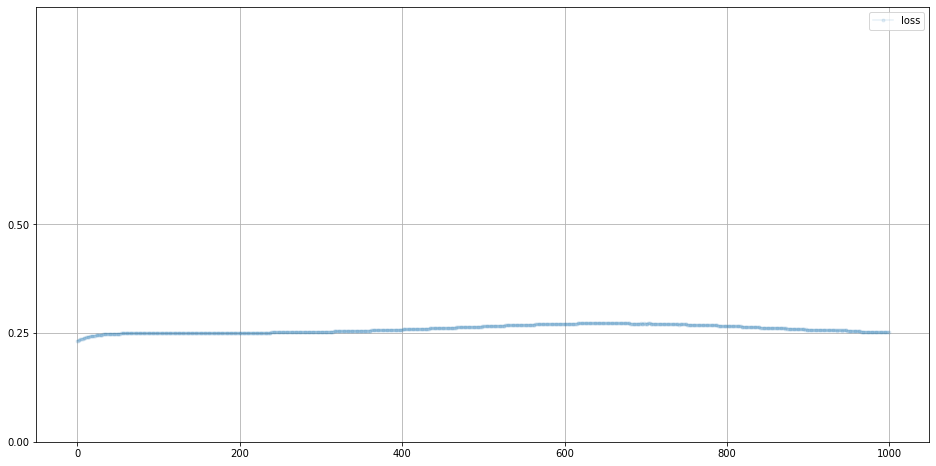

In [ ]:
# plot generator error

G.plot_progress()

In [ ]:
# manually run generator to see it's outputs

G.forward(torch.cuda.FloatTensor([0.5]))

tensor([0.8798, 0.0844, 0.8778, 0.1233], grad_fn=<SigmoidBackward0>)

In [ ]:
import numpy

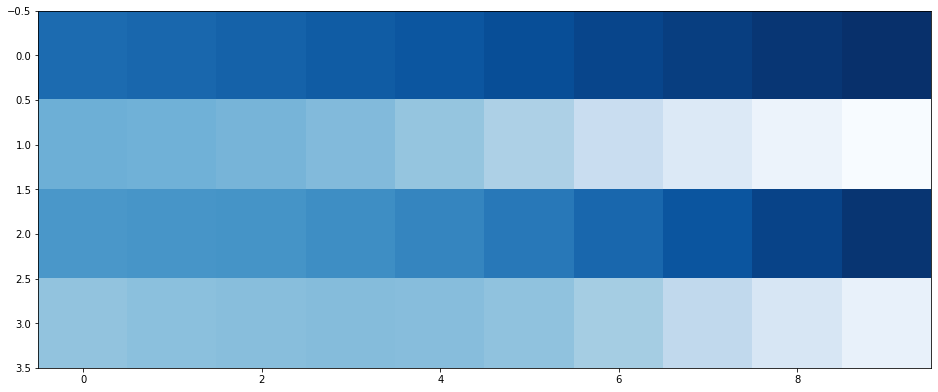

In [ ]:
# plot images collected during training

plt.figure(figsize = (16,8))

plt.imshow(numpy.array(image_list).T, interpolation='none', cmap='Blues')